In [2]:
import pandas as pd
import numpy as np

from datetime import datetime

from matplotlib import pyplot as plt 
import seaborn as sns 

from sklearn.linear_model import LinearRegression

from sklearn.preprocessing import PolynomialFeatures

from statsmodels.tsa.ar_model import ar_select_order

from sklearn.model_selection import TimeSeriesSplit, cross_val_score

import matplotlib.gridspec as gridspec

from fill_dt_data import fill_data

In [3]:
df = pd.read_csv('TG_STAID002759.txt', header=14)

In [4]:
df.columns=['source_id', 'date', 'mean_temp', 'quality_code']

In [5]:
df.columns

Index(['source_id', 'date', 'mean_temp', 'quality_code'], dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53691 entries, 0 to 53690
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   source_id     53691 non-null  int64
 1   date          53691 non-null  int64
 2   mean_temp     53691 non-null  int64
 3   quality_code  53691 non-null  int64
dtypes: int64(4)
memory usage: 1.6 MB


In [7]:
df.head(2)

,source_id,date,mean_temp,quality_code
0,127488,18760101,22,0
1,127488,18760102,25,0


In [8]:
def set_datetime(df):
    
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df.set_index('date',inplace=True)
    
    df['mean_temp'] = df['mean_temp']/10

In [9]:
set_datetime(df)

<AxesSubplot: xlabel='date'>

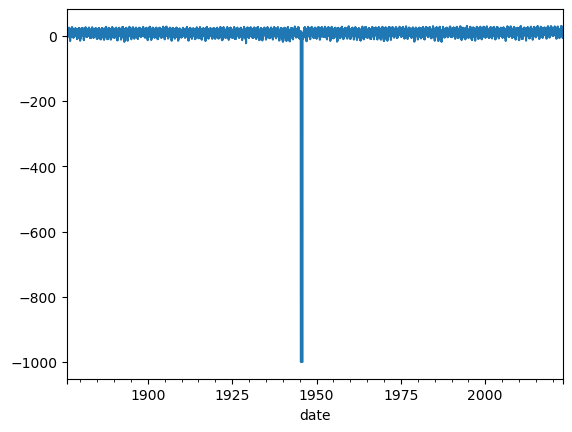

In [10]:
df.mean_temp.plot()

In [11]:
df.loc[df['quality_code']>0]

,source_id,mean_temp,quality_code,year,month,day
date,,,,,,
1945-04-25,127488,-999.9,9,1945,4,25
1945-04-26,127488,-999.9,9,1945,4,26
1945-04-27,127488,-999.9,9,1945,4,27
1945-04-28,127488,-999.9,9,1945,4,28
1945-04-29,127488,-999.9,9,1945,4,29
...,...,...,...,...,...,...
1945-11-01,127488,-999.9,9,1945,11,1
1945-11-02,127488,-999.9,9,1945,11,2
1945-11-03,127488,-999.9,9,1945,11,3


In [12]:
start = '1945-04-25'
end = '1945-11-05'
column = 'mean_temp'

In [13]:
df = fill_data(df, column, start, end)

In [14]:
df.loc[start:end]

,source_id,mean_temp,quality_code,year,month,day
date,,,,,,
1945-04-25,127488,11.2,9,1945,4,25
1945-04-26,127488,10.8,9,1945,4,26
1945-04-27,127488,10.4,9,1945,4,27
1945-04-28,127488,10.2,9,1945,4,28
1945-04-29,127488,9.8,9,1945,4,29
...,...,...,...,...,...,...
1945-11-01,127488,5.3,9,1945,11,1
1945-11-02,127488,5.0,9,1945,11,2
1945-11-03,127488,6.1,9,1945,11,3


In [16]:
def delete_outliers(data, df):
    
    mean = np.mean(data)
    std = np.std(data)
    
    outliers = np.abs(data - mean) > (3 * std)
    
    df.drop(index=data[outliers].index, inplace=True)

In [17]:
df['timestep'] = list(range(len(df)))

In [18]:
df_train = df[:-365]

df_test = df[-365:]

In [19]:
len(df_train)

53326

In [20]:
delete_outliers(df_train['mean_temp'], df_train)

/var/folders/yg/k2ykb91n2gq_9nxx2ztytxlh0000gn/T/ipykernel_25638/3173075994.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(index=data[outliers].index, inplace=True)


In [21]:
len(df_train)

53271

In [22]:
delete_outliers(df_train['mean_temp'], df_train)

/var/folders/yg/k2ykb91n2gq_9nxx2ztytxlh0000gn/T/ipykernel_25638/3173075994.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(index=data[outliers].index, inplace=True)


In [23]:
len(df_train)

53265

<AxesSubplot: xlabel='year'>

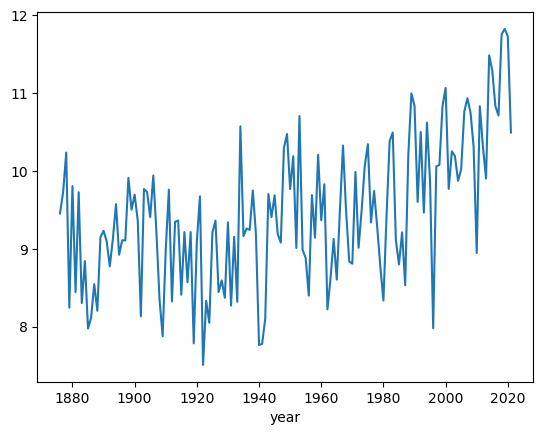

In [24]:
df_train.groupby('year')['mean_temp'].mean().plot()

# Linear Regression

In [25]:
lin_reg = LinearRegression()

In [26]:
X = df_train[['timestep']]
y = df_train.mean_temp
lin_reg.fit(X, y)

LinearRegression()

In [27]:
df_train['trend'] = lin_reg.predict(X)
df_train.head()

/var/folders/yg/k2ykb91n2gq_9nxx2ztytxlh0000gn/T/ipykernel_25638/4217390922.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['trend'] = lin_reg.predict(X)


,source_id,mean_temp,quality_code,year,month,day,timestep,trend
date,,,,,,,,
1876-01-01,127488,2.2,0,1876,1,1,0,8.561545
1876-01-02,127488,2.5,0,1876,1,2,1,8.561578
1876-01-03,127488,0.3,0,1876,1,3,2,8.561612
1876-01-04,127488,-5.8,0,1876,1,4,3,8.561645
1876-01-05,127488,-9.8,0,1876,1,5,4,8.561678


In [28]:
def plot_flights(df, title='Mean Temp in C over Time', ylim=True):
    '''
    Custom plotting function for plotting the flights dataset
    
    Parameters
    ----------
    df : pd.DataFrame
        The data to plot.
    title : str
        The title of the plot
    ylim : bool
        Whether to fix the minimum value of y; defalut is True
    
    Returns
    -------
    Plots the data
    '''
    df.plot()
    plt.title(title)
    plt.ylabel('# of Passengers in 1000')
    if ylim:
        plt.ylim(ymin=-27)
    plt.show()

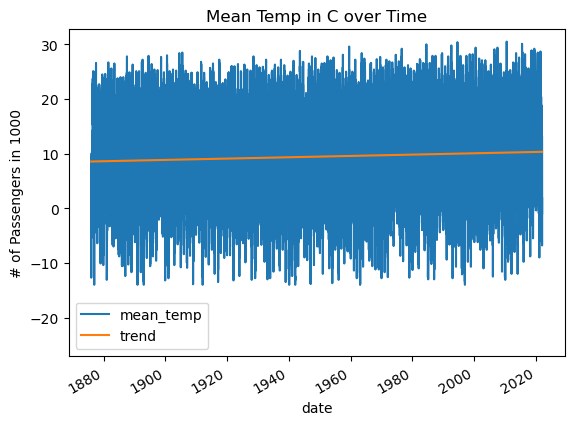

In [29]:
plot_flights(df_train[['mean_temp', 'trend']])

/var/folders/yg/k2ykb91n2gq_9nxx2ztytxlh0000gn/T/ipykernel_25638/2579718148.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_train.groupby('year')['mean_temp','trend'].mean().plot()


<AxesSubplot: xlabel='year'>

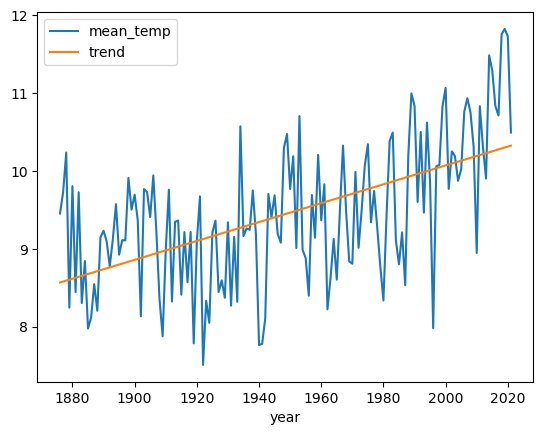

In [30]:
df_train.groupby('year')['mean_temp','trend'].mean().plot()

# Seasonality

In [31]:
seasonal_dummies = pd.get_dummies(df_train.index.month,
                                  prefix='month',
                                  drop_first=True).set_index(df_train.index)

df_train = df_train.join(seasonal_dummies)

In [32]:
X_season = df_train.drop(columns=['source_id', 'quality_code', 'mean_temp', 'year', 'month', 'day', 'trend'])

In [33]:
lin_reg_season = LinearRegression()

In [34]:
lin_reg_season.fit(X_season, y)

LinearRegression()

In [35]:
df_train['trend_seasonal'] = lin_reg_season.predict(X_season)
df_train.head()

,source_id,mean_temp,quality_code,year,month,day,timestep,trend,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal
date,,,,,,,,,,,,,,,,,,,,
1876-01-01,127488,2.2,0,1876,1,1,0,8.561545,0,0,0,0,0,0,0,0,0,0,0,-0.761995
1876-01-02,127488,2.5,0,1876,1,2,1,8.561578,0,0,0,0,0,0,0,0,0,0,0,-0.761963
1876-01-03,127488,0.3,0,1876,1,3,2,8.561612,0,0,0,0,0,0,0,0,0,0,0,-0.761930
1876-01-04,127488,-5.8,0,1876,1,4,3,8.561645,0,0,0,0,0,0,0,0,0,0,0,-0.761897
1876-01-05,127488,-9.8,0,1876,1,5,4,8.561678,0,0,0,0,0,0,0,0,0,0,0,-0.761865


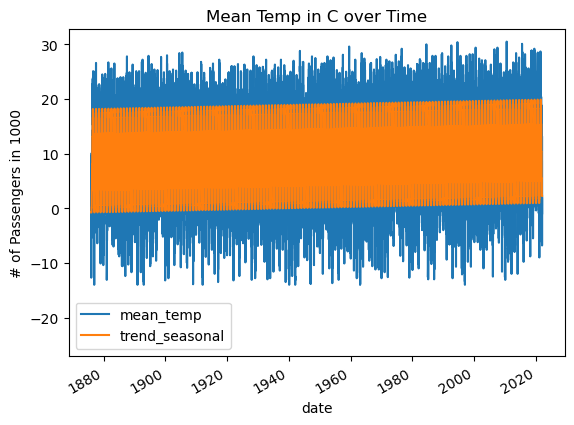

In [36]:
plot_flights(df_train[['mean_temp', 'trend_seasonal']])

/var/folders/yg/k2ykb91n2gq_9nxx2ztytxlh0000gn/T/ipykernel_25638/690246427.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_train.groupby('year')['mean_temp', 'trend_seasonal'].mean().plot()


<AxesSubplot: xlabel='year'>

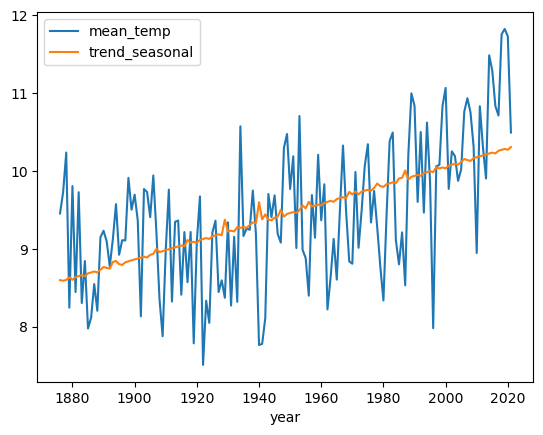

In [37]:
df_train.groupby('year')['mean_temp', 'trend_seasonal'].mean().plot()

# Find Remainder

In [38]:
df_train['remainder'] = df_train.mean_temp - df_train.trend_seasonal

In [39]:
df_train.head()

,source_id,mean_temp,quality_code,year,month,day,timestep,trend,month_2,month_3,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder
date,,,,,,,,,,,,,,,,,,,,,
1876-01-01,127488,2.2,0,1876,1,1,0,8.561545,0,0,...,0,0,0,0,0,0,0,0,-0.761995,2.961995
1876-01-02,127488,2.5,0,1876,1,2,1,8.561578,0,0,...,0,0,0,0,0,0,0,0,-0.761963,3.261963
1876-01-03,127488,0.3,0,1876,1,3,2,8.561612,0,0,...,0,0,0,0,0,0,0,0,-0.761930,1.061930
1876-01-04,127488,-5.8,0,1876,1,4,3,8.561645,0,0,...,0,0,0,0,0,0,0,0,-0.761897,-5.038103
1876-01-05,127488,-9.8,0,1876,1,5,4,8.561678,0,0,...,0,0,0,0,0,0,0,0,-0.761865,-9.038135


<AxesSubplot: xlabel='year'>

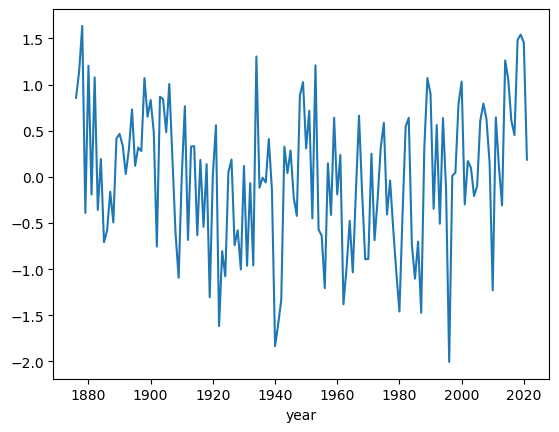

In [40]:
df_train.groupby('year')['remainder'].mean().plot()

In [41]:
#df_train['remainder'].to_csv('temp_remainder.csv')

# Lag features

In [42]:
lag_df = pd.read_csv('temp_remainder.csv', index_col=0, parse_dates=True)

In [43]:
lags_order = ar_select_order(lag_df, maxlag=5)

/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [44]:
lags_order.ar_lags

[1, 2, 3, 4]

In [45]:
lag_df['lag1'] = lag_df['remainder'].shift(1)

In [46]:
lag_df.head(2)

,remainder,lag1
date,,
1876-01-01,2.962135,NaN
1876-01-02,3.262102,2.962135


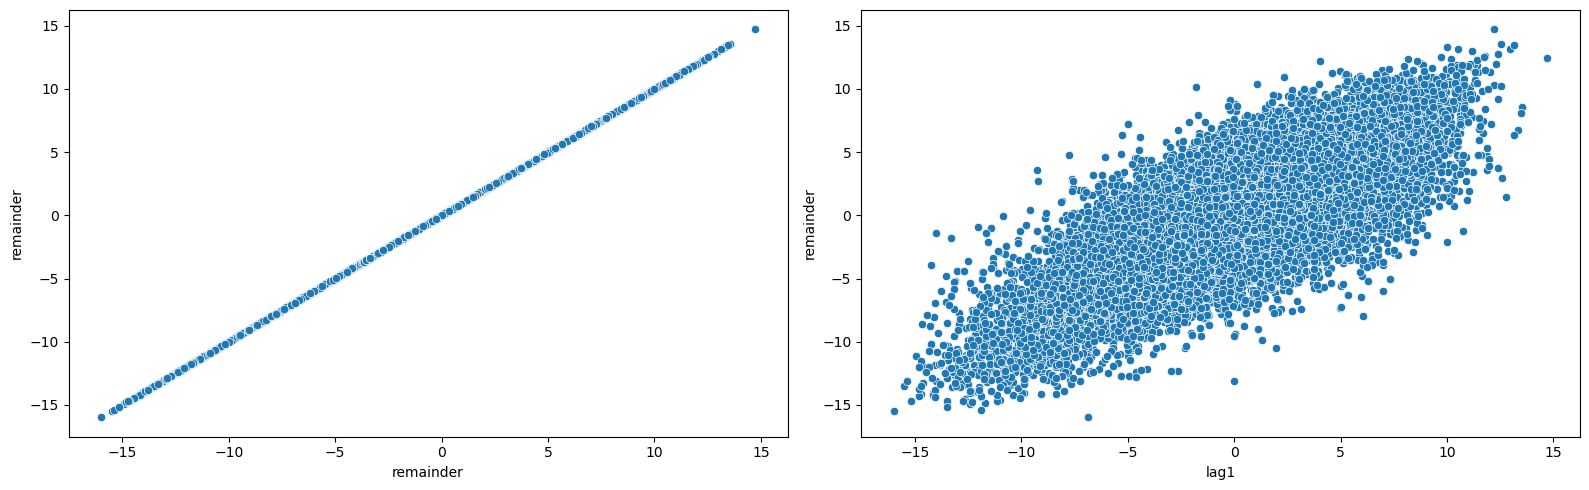

In [47]:
p=2
lag_columns = lag_df.columns[-p:]
fig, axes = plt.subplots(1,p, figsize=(16,5),dpi=100)
gs = gridspec.GridSpec(1,p)

for i in range(p):
    sns.scatterplot(x=lag_df[lag_columns[i]],y=lag_df['remainder'],ax=axes[i])
    
plt.tight_layout()

In [48]:
round(lag_df[['remainder', 'lag1']].corr(), 2)

,remainder,lag1
remainder,1.0,0.8
lag1,0.8,1.0


In [49]:
lag_df.drop('remainder',axis=1,inplace=True)

In [50]:
lag_df

,lag1
date,
1876-01-01,NaN
1876-01-02,2.962135
1876-01-03,3.262102
1876-01-04,1.062069
1876-01-05,-5.037963
...,...
2021-12-27,-9.067427
2021-12-28,-6.167460
2021-12-29,-2.767493


In [51]:
df_train.head(5)

,source_id,mean_temp,quality_code,year,month,day,timestep,trend,month_2,month_3,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder
date,,,,,,,,,,,,,,,,,,,,,
1876-01-01,127488,2.2,0,1876,1,1,0,8.561545,0,0,...,0,0,0,0,0,0,0,0,-0.761995,2.961995
1876-01-02,127488,2.5,0,1876,1,2,1,8.561578,0,0,...,0,0,0,0,0,0,0,0,-0.761963,3.261963
1876-01-03,127488,0.3,0,1876,1,3,2,8.561612,0,0,...,0,0,0,0,0,0,0,0,-0.761930,1.061930
1876-01-04,127488,-5.8,0,1876,1,4,3,8.561645,0,0,...,0,0,0,0,0,0,0,0,-0.761897,-5.038103
1876-01-05,127488,-9.8,0,1876,1,5,4,8.561678,0,0,...,0,0,0,0,0,0,0,0,-0.761865,-9.038135


In [52]:
df_train = df_train.join(lag_df)

In [53]:
df_train.head(2)

,source_id,mean_temp,quality_code,year,month,day,timestep,trend,month_2,month_3,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1
date,,,,,,,,,,,,,,,,,,,,,
1876-01-01,127488,2.2,0,1876,1,1,0,8.561545,0,0,...,0,0,0,0,0,0,0,-0.761995,2.961995,NaN
1876-01-02,127488,2.5,0,1876,1,2,1,8.561578,0,0,...,0,0,0,0,0,0,0,-0.761963,3.261963,2.962135


In [54]:
df_train.dropna(inplace=True)

In [55]:
cols = ['timestep', 'month_2', 'month_3', 
        'month_4', 'month_5', 'month_6', 
        'month_7', 'month_8', 'month_9', 
        'month_10', 'month_11', 'month_12', 'lag1']

In [56]:
X_lags = df_train[cols]
y_lags = df_train['mean_temp']

In [57]:
lin_reg_lag = LinearRegression()

In [58]:
lin_reg_lag.fit(X_lags, y_lags)

LinearRegression()

In [59]:
df_train['temp_preds'] = lin_reg_lag.predict(X_lags)
df_train.head()

,source_id,mean_temp,quality_code,year,month,day,timestep,trend,month_2,month_3,...,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,temp_preds
date,,,,,,,,,,,,,,,,,,,,,
1876-01-02,127488,2.5,0,1876,1,2,1,8.561578,0,0,...,0,0,0,0,0,0,-0.761963,3.261963,2.962135,1.636486
1876-01-03,127488,0.3,0,1876,1,3,2,8.561612,0,0,...,0,0,0,0,0,0,-0.761930,1.061930,3.262102,1.876840
1876-01-04,127488,-5.8,0,1876,1,4,3,8.561645,0,0,...,0,0,0,0,0,0,-0.761897,-5.038103,1.062069,0.114301
1876-01-05,127488,-9.8,0,1876,1,5,4,8.561678,0,0,...,0,0,0,0,0,0,-0.761865,-9.038135,-5.037963,-4.772751
1876-01-06,127488,-7.7,0,1876,1,6,5,8.561711,0,0,...,0,0,0,0,0,0,-0.761832,-6.938168,-9.037996,-7.977372


/var/folders/yg/k2ykb91n2gq_9nxx2ztytxlh0000gn/T/ipykernel_25638/521440919.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_train.groupby('year')['mean_temp','temp_preds'].mean().plot()


<AxesSubplot: xlabel='year'>

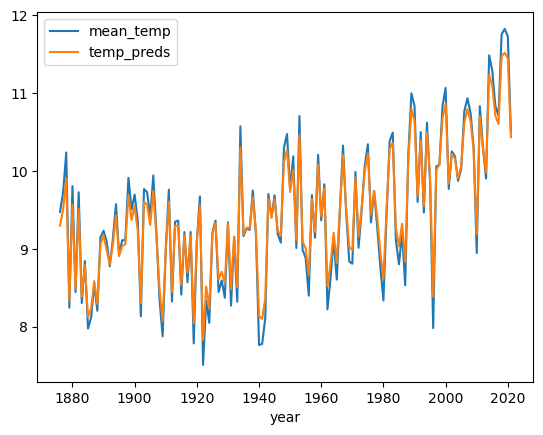

In [60]:
df_train.groupby('year')['mean_temp','temp_preds'].mean().plot()

/var/folders/yg/k2ykb91n2gq_9nxx2ztytxlh0000gn/T/ipykernel_25638/4188246933.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_train.groupby('month')['mean_temp','temp_preds'].mean().plot()


<AxesSubplot: xlabel='month'>

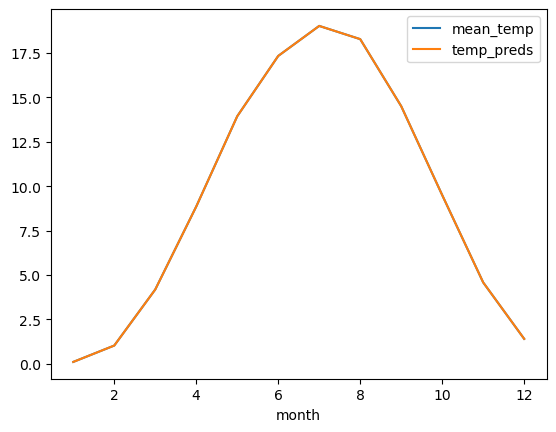

In [61]:
df_train.groupby('month')['mean_temp','temp_preds'].mean().plot()

In [62]:
ts_split = TimeSeriesSplit(n_splits=20)

In [63]:
time_series_split = ts_split.split(X_lags, y_lags)

In [64]:
result = cross_val_score(estimator=lin_reg_lag, X=X_lags, y=y_lags, cv=time_series_split)
result

array([0.9153031 , 0.9207374 , 0.91468878, 0.90929716, 0.90055061,
       0.88915134, 0.90202895, 0.90470189, 0.91644029, 0.91770617,
       0.91224841, 0.91276232, 0.9120542 , 0.91011408, 0.91229396,
       0.89264011, 0.90709794, 0.92013661, 0.92033916, 0.91209122])

In [65]:
round(result.mean(), 3)

0.91

# TEST DATA TIME!

In [66]:
df_test.head(2)

,source_id,mean_temp,quality_code,year,month,day,timestep
date,,,,,,,
2022-01-01,111448,12.0,0,2022,1,1,53326
2022-01-02,111448,9.9,0,2022,1,2,53327


### Find the seasonal with dummies and linear regression

In [67]:
y_test = df_test['mean_temp']

In [68]:
test_dummies = pd.get_dummies(df_test.index.month,
                              prefix='month',
                              drop_first=True).set_index(df_test.index)

df_test = df_test.join(test_dummies)

In [69]:
X_season_test = (df_test.drop(columns=['source_id', 'quality_code', 
                                       'mean_temp', 'year', 'month', 
                                       'day']))

In [70]:
df_test['trend_seasonal'] = lin_reg_season.predict(X_season_test)

### Find the remainder by subtracting the mean_temp from the seasonal

In [71]:
df_test['remainder'] = df_test.mean_temp - df_test.trend_seasonal

### Find the lag features for the remainder

In [72]:
df_test['lag1'] = df_test['remainder'].shift(1)

### Set up features to use in prediction and drop NaN

In [73]:
cols = ['timestep', 'month_2', 'month_3', 
        'month_4', 'month_5', 'month_6', 
        'month_7', 'month_8', 'month_9', 
        'month_10', 'month_11', 'month_12', 'lag1']

In [74]:
#df_test['lag1'][0] = df_train['remainder'][-1]

In [75]:
df_test.dropna(inplace=True)

In [76]:
X_lags_test = df_test[cols]

# Predict 'Validation'

In [77]:
df_test['temp_preds'] = lin_reg_lag.predict(X_lags_test)

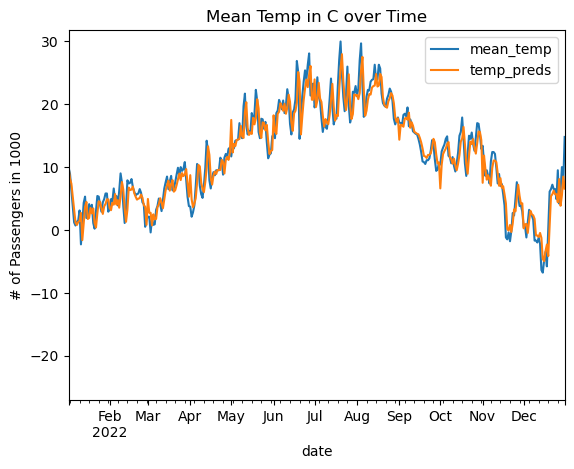

In [78]:
plot_flights(df_test[['mean_temp', 'temp_preds']])

/var/folders/yg/k2ykb91n2gq_9nxx2ztytxlh0000gn/T/ipykernel_25638/89338637.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_test.groupby('month')['mean_temp','temp_preds'].mean().plot()


<AxesSubplot: xlabel='month'>

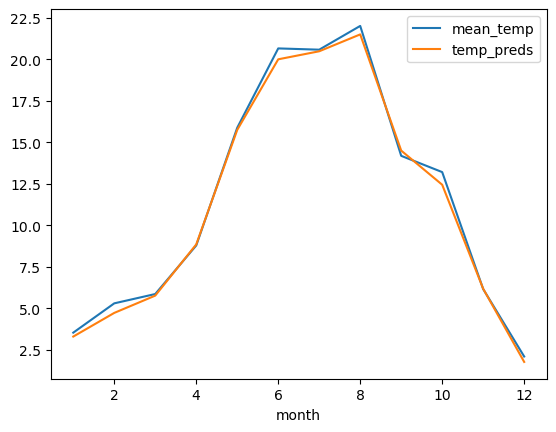

In [79]:
df_test.groupby('month')['mean_temp','temp_preds'].mean().plot()

In [80]:
print(f"Score with only Seasonal trends: {lin_reg_season.score(X_season_test, y_test)}")

Score with only Seasonal trends: 0.7423804983730892


In [81]:
print(f"Score with lag features: {lin_reg_lag.score(X_lags_test, y_test[1:])}")

Score with lag features: 0.9128362936048247


# PREDICT THE FUTURE!!!!

In [82]:
df_train.tail()

,source_id,mean_temp,quality_code,year,month,day,timestep,trend,month_2,month_3,...,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,temp_preds
date,,,,,,,,,,,,,,,,,,,,,
2021-12-27,111448,-3.9,0,2021,12,27,53321,10.331627,0,0,...,0,0,0,0,0,1,2.267122,-6.167122,-9.067427,-4.971507
2021-12-28,111448,-0.5,0,2021,12,28,53322,10.331660,0,0,...,0,0,0,0,0,1,2.267154,-2.767154,-6.167460,-2.648145
2021-12-29,111448,4.5,0,2021,12,29,53323,10.331693,0,0,...,0,0,0,0,0,1,2.267187,2.232813,-2.767493,0.075795
2021-12-30,111448,9.3,0,2021,12,30,53324,10.331726,0,0,...,0,0,0,0,0,1,2.267220,7.032780,2.232474,4.081587
2021-12-31,111448,13.0,0,2021,12,31,53325,10.331759,0,0,...,0,0,0,0,0,1,2.267252,10.732748,7.032442,7.927147


In [83]:
combined = df_train.append(df_test)

/var/folders/yg/k2ykb91n2gq_9nxx2ztytxlh0000gn/T/ipykernel_25638/383326644.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  combined = df_train.append(df_test)


In [84]:
combined.loc[combined.index=='2022-01-02']

,source_id,mean_temp,quality_code,year,month,day,timestep,trend,month_2,month_3,...,month_7,month_8,month_9,month_10,month_11,month_12,trend_seasonal,remainder,lag1,temp_preds
date,,,,,,,,,,,,,,,,,,,,,
2022-01-02,111448,9.9,0,2022,1,2,53327,NaN,0,0,...,0,0,0,0,0,0,0.980005,8.919995,11.020028,9.835627


In [85]:
X_combined = combined.drop(columns = ['source_id', 'mean_temp', 'quality_code', 'year', 'month', 'day', 'trend', 'trend_seasonal', 'remainder', 'temp_preds'])
season_combined = combined.drop(columns = ['source_id', 'mean_temp', 'quality_code', 'year', 'month', 'day', 'trend', 'trend_seasonal', 'remainder', 'temp_preds', 'lag1'])
y_combined = combined['mean_temp']

In [86]:
X_combined

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
date,,,,,,,,,,,,,
1876-01-02,1,0,0,0,0,0,0,0,0,0,0,0,2.962135
1876-01-03,2,0,0,0,0,0,0,0,0,0,0,0,3.262102
1876-01-04,3,0,0,0,0,0,0,0,0,0,0,0,1.062069
1876-01-05,4,0,0,0,0,0,0,0,0,0,0,0,-5.037963
1876-01-06,5,0,0,0,0,0,0,0,0,0,0,0,-9.037996
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,53686,0,0,0,0,0,0,0,0,0,0,1,7.220988
2022-12-28,53687,0,0,0,0,0,0,0,0,0,0,1,1.920955
2022-12-29,53688,0,0,0,0,0,0,0,0,0,0,1,4.020922


In [87]:
m_combined = LinearRegression()
m_combined.fit(X_combined, y_combined)

LinearRegression()

In [88]:
seasonal_combined = LinearRegression()
seasonal_combined.fit(season_combined, y_combined)

LinearRegression()

In [89]:
timestep = combined['timestep'].max() + 1
months = [0] * 11  # array of zeroes
lag = combined.loc['2022-12-31', 'remainder']

In [90]:
X_future_seasons = [timestep]
X_future_seasons

[53691]

In [91]:
X_future_seasons.extend(months)
X_future_seasons

[53691, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [92]:
X_future_seasons = pd.DataFrame([X_future_seasons])
X_future_seasons.columns = season_combined.columns

X_future_seasons

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,53691,0,0,0,0,0,0,0,0,0,0,0


In [93]:
X_future = [timestep]

In [94]:
X_future.extend(months)
X_future

[53691, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [95]:
X_future.append(lag)
X_future

[53691, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 12.520824360474185]

In [96]:
X_combined.columns

Index(['timestep', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12',
       'lag1'],
      dtype='object')

In [97]:
X_future = pd.DataFrame([X_future])
X_future.columns = X_combined.columns

In [98]:
X_future

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,lag1
0,53691,0,0,0,0,0,0,0,0,0,0,0,12.520824


In [297]:
print(f"Prediction with lags for 1 Jan 2023 is: {m_combined.predict(X_future)}")

Prediction with lags for 1 Jan 2023 is: [11.0573301]


In [298]:
print(f"Prediction with only seasonal trends is: {seasonal_combined.predict(X_future_seasons)}")

Prediction with only seasonal trends is: [1.03347649]


In [312]:
timestep2 = combined['timestep'].max() + 2 # since we had +1 in the earlier one
months2 = [0]*11
lag2 = 0

In [313]:
X_future_season_2 = pd.DataFrame([[timestep2] + months2], columns = season_combined.columns)
X_future_season_2

,timestep,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,53692,0,0,0,0,0,0,0,0,0,0,0


In [314]:
X_future_2 = [timestep2]

In [315]:
X_future_2.extend(months2)
X_future_2

[53692, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [316]:
X_future_2.append(lag2)
X_future_2

[53692, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [317]:
X_future_2 = pd.DataFrame([X_future_2])
X_future_2.columns = X_combined.columns

In [318]:
print(f"Prediction with lags for 2 Jan 2023 is: {m_combined.predict(X_future_2)}")

Prediction with lags for 2 Jan 2023 is: [1.02541349]


In [319]:
print(f"Prediction for 2 Jan 2023 based on seasonal trends is: {seasonal_combined.predict(X_future_season_2)}")

Prediction for 2 Jan 2023 based on seasonal trends is: [1.03351009]
